<img src="https://mcgillmed.com/wp-content/uploads/2021/09/MSS-Radiology-Interest-Group_logo-David-Nassim-pdf.jpg" width='500' height="355">
</div>

**AI Chest X-ray workshop, June 26th, 2024** <br/> <br/>Created by Luis Henry Gonzalez.
 <br/> luis.gonzaleztorres@mail.mcgill.ca</strong>


# Introduction to AI Model Building in Radiology

Welcome to this pilot project on artificial intelligence (AI) in radiology by MRIG. In this Google colab notebook, we will guide you through the essential steps of building an AI model for a classification task. Specifically, our goal will be to develop, train, and validate a model capable of predicting the presence of pneumonia from chest X-rays.


## Technologies and Tools
- Python: A popular programming language used in data science and machine learning.
- PyTorch/PyTorch Lightning: Frameworks for building and training machine learning models.
- DICOM: Standard format for communicating and managing medical imaging information.

We hope you will enjoy this workshop!!


In [ ]:
x = 20
y = 30
print(x+y)


50


# Setting Up Your Google colab Environment

Before we dive into the hands-on part of building our AI model, we need to set up our programming environment. This setup includes installing necessary libraries and importing them into our notebook. These tools and libraries will help us handle data, build the model, and perform computations effectively.

### Step 1: Mounting Google Drive
To access all the necessary files directly from the Google Drive, we need to mount it. This can be done with a few lines of code. Run the following command in the next code cell:


<img src= 'https://drive.google.com/uc?export=download&id=1oqH81EjRZkelinTMFUEILsIn7QMuBjj5'>



In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries and Packages

We will use `pip`, the Python package installer, to download and install several key libraries. If you are running this notebook in a local environment, ensure your Python installation is up-to-date. Here are the libraries we'll be installing:

Let’s proceed by importing these libraries and packages. The following 2 code cell should be executed to ensure all tools are loaded properly and are ready for use.


**Import Libraries**
`PyDICOM`, `torchmetrics` and `PyTorch` are not automatically installed in Colab, so we need to manually install them.

In [ ]:
!pip install -q torchmetrics
!pip install -q pytorch-lightning
!pip install -q pydicom

Run this cell to import all the required modules

In [ ]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import Image, display

# Data Preprocessing

In this section, we focus on preparing our dataset for the upcoming machine learning tasks. Let's not forget that for this excercise the data is stored in a Google Drive, but usualy it is store in you computer or in a hard drive connected to your computer

## Loading Data from CSV File

We will load our dataset from a CSV file. This file contains the information about our CXRs needed for training our AI model.

Here's how we do it:



In [ ]:
# Replace 'file_path' with the path to folder name where your data .csv is located
file_path = '/content/drive/My Drive/MRIG_AI_CXR/stage_2_train_labels.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify it's loaded correctly
labels = pd.read_csv(file_path)
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


## Understanding our Dataset

Our dataset includes several key columns that are critical for our analysis:
- **Patient ID**: This is the unique identifier for each patient.
- **Target**: Indicates the presence (1) or absence (0) of pneumonia. This is our label for the classification task.
- **X, Y, Width, Height**: These columns provide the coordinates and dimensions of the detected pneumonia regions in the X-ray images. For the purpose of this event, we will not utilize these columns but instead focus on the binary classification task.

### Handling Duplicates in the Dataset
It is important to always understand the data we are working with. For example, our dataset might contain multiple entries for the same patient, representing different detected pneumonia spots. Each spot is treated individually, resulting in multiple rows per patient. However, for our task of classifying whether a patient has pneumonia (regardless of the number of spots), we need to remove duplicates.

In [ ]:
# Remove duplicate entries
labels = labels.drop_duplicates("patientId")

** Configuring Paths for Data Files**

**DICOM Files Path**
The DICOM files, which are our all raw X-ray images, are stored in a specific directory on Google Drive. We need to define this path. - ROOT_PATH

**Processed Files Path**
After converting the DICOM files into NumPy arrays (`.npy` format), we need a designated place to store these processed files. - SAVE_PATH



In [ ]:
ROOT_PATH = Path("/content/drive/My Drive/MRIG_AI_CXR/stage_2_train_images/")
SAVE_PATH = Path("/content/drive/My Drive/My Drive/MRIG_AI_CXR/Processed/")

Let's take a look at some of the chest X-ray images we have in our dataset. The following code will iterate through the first few images

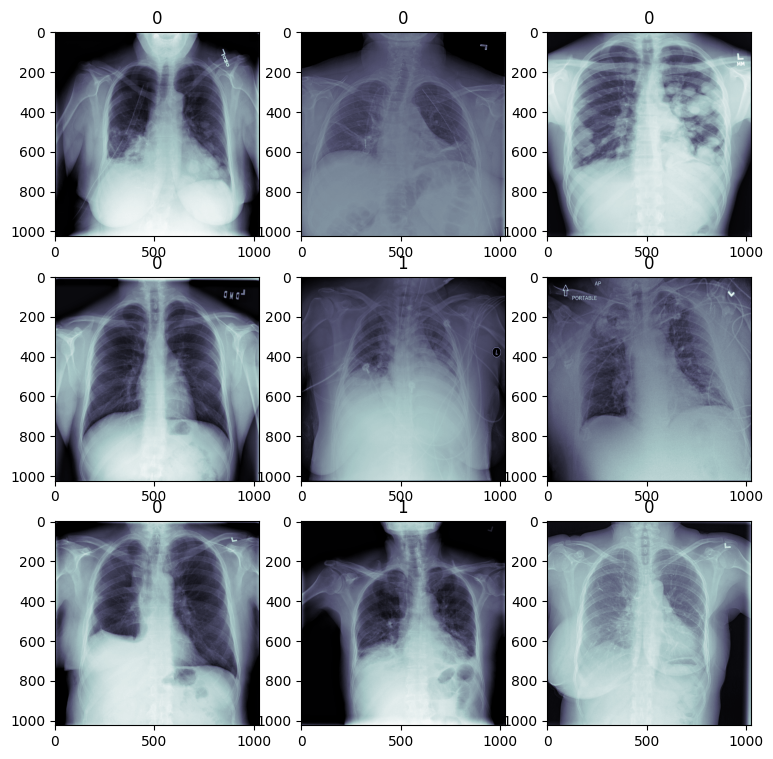

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array

        label = labels["Target"].iloc[c]

        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

##  DICOM --> NPY --> Tensor

In order to efficiently handle our data load in our model, we have to convert the X-Ray images stored in the DICOM format to numpy arrays (npy files). Afterwards we compute the overall mean and standard deviation of the pixels of the whole dataset, for the purpose of normalization.
Then the created numpy images are stored in two separate folders according to their binary label:
* 0: All X-Rays which do not show signs of pneumonia
* 1: All X-Rays which show signs of pneumonia

### !!!! DO NOT RUN THE FOLLWOING CODE!!!!!

At least not for now. This is a very time-consuming process, and for time-saving purposes, it was already done for you. This shows you an example of what to do with raw DICOM files.

We then directly save the standardized and resized files into the corresponding directory (0 for healthy, 1 for pneumonia).
This allows to take advantage of the ready-to-use torchvision **DatasetFolder** for simple file reading

We standardize all images by the maximum pixel value in the provided dataset, 255. When we divide the pixel values by 255, each pixel value (originally in the range [0, 255]) is rescaled to be in the range [0, 1].
This is called normalization and will help the model converge faster during training.
Our current images are over 1000 x 1000 pixels.
All images will be resized to 224x224 to be manageable.

To compute dataset mean and standard deviation, we compute the sum of the pixel values as well as the sum of the squared pixel values for each subject.
This allows to compute the overall mean and standard deviation without keeping the whole dataset in memory.

In [ ]:
sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix

    # Read the dicom file with pydicom and standardize the array
    dcm = pydicom.read_file(dcm_path).pixel_array / 255

    # Resize the image as 1024x1024 is way to large to be handeled by Deep Learning models at the moment
    # Let's use a shape of 224x224
    # In order to use less space when storing the image we convert it to float16
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

    # Retrieve the corresponding label
    label = labels.Target.iloc[c]

    # 4/5 train split, 1/5 val split
    train_or_val = "train" if c < 24000 else "val"

    current_save_path = SAVE_PATH/train_or_val/str(label) # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory

    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
    if train_or_val == "train":  # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

In [ ]:
mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))

We will use mean and std later in the dataloader to normalize our data

In [ ]:
print(f"Mean of Dataset: {mean}, STD: {std}")

## Create the data sets to training and validate our model


<img src="https://labelyourdata.com/img/article-illustrations/splitting-data-set.png" width='700' height="300" > <br /> We can leverage the **DatasetFolder** function from torchvision: It allows to simply pass a root directory and return return a dataset object with access to all files within the directory and the directory name as class label. <br />
1) We need to define a loader function, **load_file**, which defines how the files shall be loaded.
This is very comfortable as we only have to load our previously stored numpy files.
Additionally, we need to define a list of file extensions (just "npy" in our case).

2) we can pass a transformation sequence for Data Augmentation and Normalization.

We use:
* RandomResizedCrops which applies a random crop of the image and resizes it to the original image size (224x224)
* Random Rotations between -5 and 5 degrees
* Random Translation (max 5%)
* Random Scaling (0.9-1.1 of original image size)

Lets load the following cells to save time!!

In [ ]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [ ]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])



In our case, both the training and validation data have been created in advance. We simply have to retrieve them from the Google Drive folder.

In [ ]:
train_path = "/content/drive/My Drive/MRIG_AI_CXR/Processed/train"
val_path = "/content/drive/My Drive/MRIG_AI_CXR/Processed/val"

Creating the datasets might take a few minutes (<5mins)

In [ ]:
train_dataset = torchvision.datasets.DatasetFolder(
    train_path,
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    val_path,
    loader=load_file, extensions="npy", transform=val_transforms)

**DataLoader Setup and Dataset Overview**

This code sets up the data loaders for our training and validation datasets using PyTorch's `DataLoader` function. It organizes the data into batches, which are essential for training the model efficiently.

- `batch_size`: The number of images processed before the model's internal parameters are updated.
- `num_workers`: The number of subprocesses to use for data loading. More workers can speed up the data loading process.
- `shuffle`: True for the training loader to randomize the order of images to prevent the model from learning the sequence of the data, improving generalization.



In [ ]:
batch_size = 64#TODO
num_workers = 4# TODO

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407])), (array([0, 1]), array([2079,  605])))

***The classes are imbalanced***: There are more images without signs of

pneumonia than with pneumonia.

There are multiple ways to deal with imbalanced datasets:
* Weighted Loss
* Doing nothing :)

The template to define a customized weighted loss function is provided below and feel free to play around with a weighted loss.


Let's inspect some transformed training images.

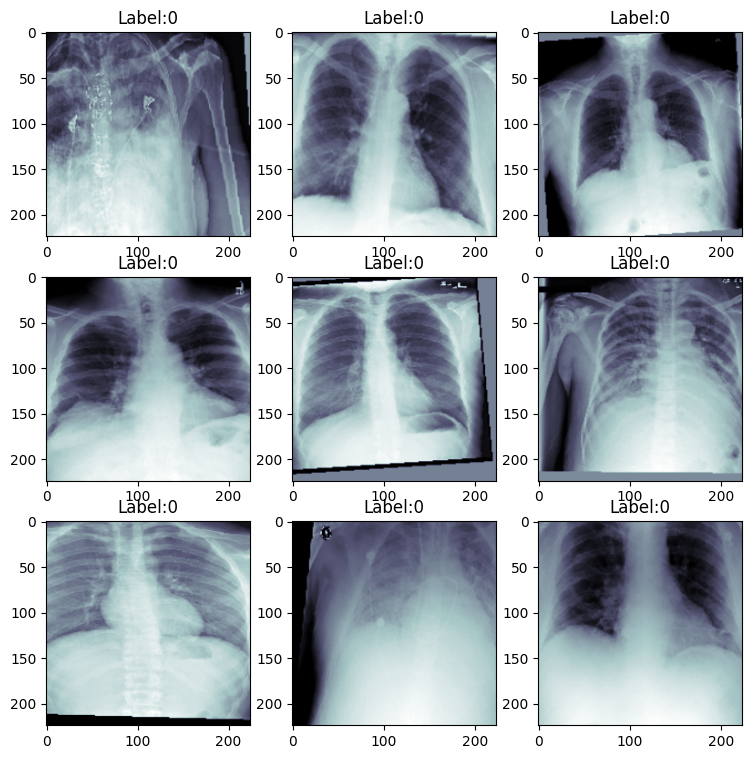

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

Type: DatasetFolder with 24,000 images.
Location: Stored at /content/drive/My Drive/MRIG_AI_CXR/Processed/train.
Preprocessing Transforms
ToTensor(): Converts images to tensors.
Normalize(mean=0.49, std=0.248): Adjusts pixel values for stable learning.
RandomAffine: Adds rotation, translation, and scaling for data variation.
RandomResizedCrop: Crops and resizes images
These transformations prepare the dataset for effective AI training, enhancing model robustness.



In [ ]:
train_dataset

Dataset DatasetFolder
    Number of datapoints: 24000
    Root location: /content/drive/My Drive/MRIG_AI_CXR/Processed/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.49, std=0.248)
               RandomAffine(degrees=[-5.0, 5.0], translate=(0, 0.05), scale=(0.9, 1.1))
               RandomResizedCrop(size=(224, 224), scale=(0.35, 1), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
           )

In [ ]:
val_dataset

Dataset DatasetFolder
    Number of datapoints: 2684
    Root location: /content/drive/My Drive/MRIG_AI_CXR/Processed/val
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.49], std=[0.248])
           )

When you access the first element of the `train_dataset` using `train_dataset[0]`, it returns a tuple containing two items: a tensor representing an image and its corresponding label.

1. **Tensor:** This tensor represents an image that has been processed through several transformations defined in your dataset's preprocessing steps. The values inside the tensor, ranging from negative values like `-2` to positive one like `2`, reflect the pixel intensity adjustments made by the `Normalize` transformation. These values are normalized based on the mean and standard deviation specified (`mean=0.49`, `std=0.248`)

2. **Label:** The `0` following the tensor indicates the label assigned to this image, which is no pneumonia.

In [ ]:
train_dataset[0]

(tensor([[[-1.9363, -1.9288, -1.9284,  ..., -1.9442, -1.9442, -1.9442],
          [-1.9428, -1.9301, -1.9285,  ..., -1.9442, -1.9442, -1.9442],
          [-1.9442, -1.9402, -1.9396,  ..., -1.9442, -1.9442, -1.9442],
          ...,
          [-1.9600, -1.9600, -1.9600,  ...,  0.3183,  0.1155, -0.2258],
          [-1.9583, -1.9593, -1.9575,  ...,  0.2623,  0.0392, -0.3938],
          [-1.9504, -1.9562, -1.9454,  ...,  0.2136, -0.1065, -0.7069]]]),
 0)

# AI Model Creation

**Now it is time to create the model** - We will use the ResNet18 network architecture. <br/>
* "Pneumonia detection in chest X-ray images using an ensemble of deep learning models", 2021,
Rohit Kundu https://doi.org/10.1371/journal.pone.0256630. <br/>
* "Deep Residual Learning for Image Recognition", 2016, Kaiming He doi: 10.1109/CVPR.2016.90.

Each pytorch lightning model is defined by at least an initialization method, a **forward** function which defines defines how your input data passes through the model, a **training_step** which yields the loss and **configure_optimizers** to specify the optimization algorithm.

Additionally, we can use a **training_epoch_end** callback to compute overall dataset statistics and metrics such as accuracy.

Subsequently, we define the **validation_step**. The validation step performs more or less the same steps as the training step, however, on the validation data. In this case, pytorch lightning doesn't update the weights.
Again, we can use **validation_epoch_end** to compute overall dataset metrics.

No loops or manual weight updates are needed!<br />
Additionally, pl also handles device management.  Just pass the number of GPUS when creating the trainer.

**Understanding ResNet-18**

ResNet-18 is a popular convolutional neural network (CNN) architecture used primarily for image recognition tasks. It stands for "Residual Network" and was introduced by Microsoft in the 2015 paper "Deep Residual Learning for Image Recognition." ResNet-18 consists of 18 layers, including convolutional layers, batch normalization, ReLU activations, and fully connected layers.

**Key Features:**
- **Residual Blocks:** The core idea of ResNet is the use of residual blocks, which allow the network to learn residual functions with reference to the layer inputs. This helps in training very deep networks by addressing the vanishing gradient problem.
- **Skip Connections:** These are shortcuts that skip one or more layers, allowing the gradient to flow more easily through the network during backpropagation. This makes training faster and improves accuracy.
- **Performance:** Despite its relatively shallow depth compared to other ResNet variants (like ResNet-50 or ResNet-101), ResNet-18 achieves high accuracy on various image classification benchmarks.

ResNet-18 is widely used in the AI community for its simplicity, effectiveness, and ease of implementation.
<img style="display: block;-webkit-user-select: none;margin: auto;cursor: zoom-in;background-color: hsl(0, 0%, 90%);transition: background-color 300ms;" src="https://www.researchgate.net/profile/Sampa-Misra/publication/343957273/figure/fig2/AS:930467717083136@1598852199057/ResNet-18-architecture-used-in-the-proposed-method-Res-block1-is-a-regular-ResNet-block.png" width="811" height="405">


If you load the following cell, you will see the structure of the model.

In [ ]:
torchvision.models.resnet18

<function torchvision.models.resnet.resnet18(*, weights: Optional[torchvision.models.resnet.ResNet18_Weights] = None, progress: bool = True, **kwargs: Any) -> torchvision.models.resnet.ResNet>


As most of the torchvision models, the original ResNet expects a three channel input in **conv1**. <br />
However, our X-Ray image data has only one channel - one colour gradient.
Thus we need to change the in_channel parameter from 3 to 1.

Additionally, we will change the last fully connected layer to have only one output as we have a binary class label.

In [ ]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        self.validation_step_outputs = []
        # We set the ResNet18 architecture for our model.
        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        # We use the Adam Optimizer with a learning rate of 0.0001 and the BinaryCrossEntropy Loss function.
        # Feel free to pass a weight different from 1 to the Pneumonia model in order to use the weighted loss function
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss

        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss

    def on_train_epoch_end(self):
        self.log("Train Acc", self.train_acc.compute())
        self.train_acc.reset()


    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)

        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        self.validation_step_outputs.append(loss)
        return loss

    def on_validation_epoch_end(self):
        self.log("Val Acc", self.val_acc.compute())
        self.val_acc.reset()

    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one)
        return [self.optimizer]

In [ ]:
model = PneumoniaModel()  # Instanciate the model = put the AI model all togerther

# Now time to train our model

In [ ]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

## !!!! DO NOT RUN THE FOLLWOING CODE!!!!!

Consider changing the output to safe the google drive

In [ ]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

In [ ]:
gpus = 1 #TODO, NO GPU SELECTED
trainer = pl.Trainer(devices=1, accelerator="gpu", logger=TensorBoardLogger(save_dir="/content/drive/My Drive/MRIG_AI_CXR/logs"), log_every_n_steps=1,
                     callbacks=[checkpoint_callback],
                     max_epochs=35)

#_______________________________________________**

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=35` reached.


## Loading Pre-trained Model Weights

The code above is designed to load a model with specific weights and biases identical to those provided in the designated folder. For this event, we will directly load these pre-trained weights into our built model to evaluate its performance. Training our model from scratch to achieve these weights could take many hours


# Model Evaluation

Let's evaluate our model!

First, we'll load the latest checkpoint and send the model to the GPU, if possible.

The "Weights" folder contains two sets of weights, named 1 and 3:
- `weights_1.ckpt` corresponds to the model trained with its original class imbalance.
- `weights_3.ckpt` adjusts for the class imbalance by giving three times more weight to the 'positive' class (pneumonia) compared to the 'negative' class (pneumonia).

We'll discuss the pros and cons of adjusting for class imbalance in the training process.


Here is example for Weights =1

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weight_path = "/content/drive/My Drive/MRIG_AI_CXR/weights/weights_1.ckpt"
# Use strict=False, otherwise we would want to match the pos_weight which is not necessary
model = PneumoniaModel.load_from_checkpoint(weight_path)
model.eval()
model.to(device);

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/My Drive/MRIG_AI_CXR/weights/weights_1.ckpt`


In [ ]:
# Loader f(x)
def load_file(path):
    return np.load(path).astype(np.float32)

In [ ]:
# Validation transforme f(x)
val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])
# path to the validation data set alrealy preprocess
val_path = "/content/drive/My Drive/MRIG_AI_CXR/Processed/val"

# Creation of the validation data set to use
val_dataset = torchvision.datasets.DatasetFolder(
    val_path,
    loader=load_file, extensions="npy", transform=val_transforms)

The following work could take over 20 minutes to run. It computes predictions on the complete validation set and stores both the predictions and labels.


In [ ]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

# Model Metrics Computation

This section of the code calculates key binary classification metrics:

- **Accuracy**: Is the proportion of true results (both true positives and true negatives) among the total number of cases examined. It is calculated by comparing the predictions (`preds`) with the true labels (`labels`).

- **Precision**: Measures the accuracy of positive predictions. It is the ratio of true positives to the sum of true and false positives, indicating the quality of the positive class predictions.

- **Recall**: or sensitivity indicates the ability of the model to find all the relevant cases (positive class). It is the ratio of true positives to the sum of true positives and false negatives, showing how well the model can detect the positive class.

- **Confusion Matrix**: Povides a visualization of the performance of an algorithm. It shows the counts of true positive, true negative, false positive, and false negative predictions in a matrix format.

- **Confusion Matrix with Thresholding**: A second confusion matrix is calculated with a decision threshold of 0.25. This means predictions above this threshold are considered positive. It helps in understanding the impact of changing the threshold on the model's performance.


In [ ]:
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
cm = torchmetrics.ConfusionMatrix(task="binary", num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task="binary", num_classes=2, threshold=0.25)(preds, labels)

print(f"Validation Accuracy: {acc}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix at 0.25:\n {cm_threshed}")

Validation Accuracy: 0.8457525968551636
Validation Precision: 0.7002096176147461
Validation Recall: 0.5520660877227783
Confusion Matrix:
 tensor([[1936,  143],
        [ 271,  334]])
Confusion Matrix at 0.25:
 tensor([[1725,  354],
        [ 136,  469]])


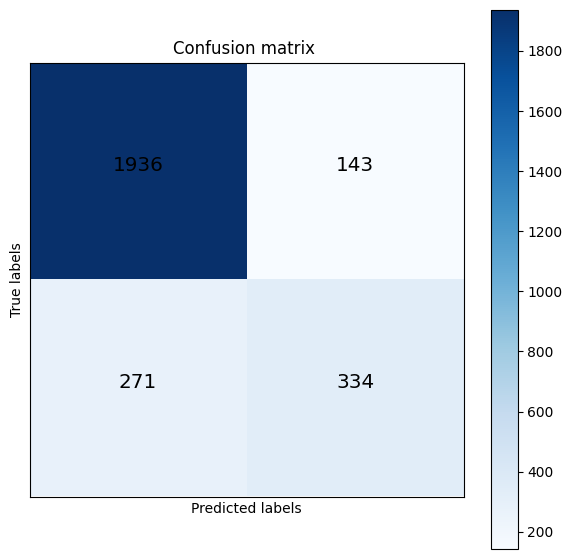

In [ ]:
cm_np = cm.numpy()
plt.figure(figsize=(7,7))
plt.imshow(cm_np, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i, j in itertools.product(range(cm_np.shape[0]), range(cm_np.shape[1])):
    plt.text(j, i, cm_np[i, j],
             horizontalalignment="center",
             color="black" if cm_np[i, j] > 120 else "black", size='x-large')
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

# Conclusion

Now, let's put our model to the test with real-world scenarios!

We will select cases from our validation dataset and display the model's predictions.


**Important Note:** Ensure that the model is properly loaded and set to `model.eval()` mode before executing the following code.


### DICOM File Processing

Take a DICOM file, extracting its pixel data, and transforming it into a tensor format.

In [ ]:
the_CXR = "/content/drive/My Drive/MRIG_AI_CXR/stage_2_test_images/c1937034-f8a4-4a84-a69c-213911b39907.dcm"  # Create the path to the DICOM file
    # my_CXR = the_CXR.with_suffix(".dcm")  # And add the .dcm suffix if not done

    # Read the DICOM file with pydicom and standardize the array
cxr = pydicom.read_file(the_CXR).pixel_array / 255

    # Resize the image from 1024x1024 to 224x224, as required by our model.
    # Convert the image to float32 to use less space when storing.
cxr_array = cv2.resize(cxr, (224, 224)).astype(np.float32)

# Convert the numpy array to a PyTorch tensor and add a batch dimension
input_tensor = torch.tensor(cxr_array).unsqueeze(0).unsqueeze(0)  # Add a channel (1, because it's grayscale) and batch dimension
# if uses CUDA
input_tensor = input_tensor.cuda()

This CXR presents pneumonia.
Probability of pneumonia: 0.8807


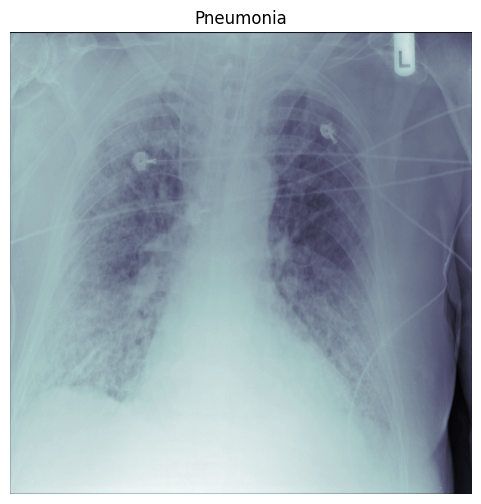

In [ ]:
# Assuming model and input_tensor are already defined and properly set up.
with torch.no_grad():
    # Forward pass through the model and apply sigmoid to get the output as a probability
    output = torch.sigmoid(model(input_tensor)[0].cpu())

    # Determine if the prediction indicates pneumonia based on the threshold 0.5
    has_pneumonia = int(output > 0.5)

    # Print a user-friendly message based on the prediction
    if has_pneumonia:
        print("This CXR presents pneumonia.")
        print(f"Probability of pneumonia: {output.item():.4f}")
    else:
        print("This CXR does not present pneumonia.")
        print(f"Probability of pneumonia: {output.item():.4f}")
# Read the DICOM file
dcm_show = pydicom.dcmread(the_CXR).pixel_array

# Creating a single subplot
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(dcm_show, cmap='bone')
prediction_probability = output.numpy()[0]
ax.set_title("Pneumonia" if int(prediction_probability > 0.5) else "No Pneumonia")  # Assign the label
ax.axis('off')

plt.show()

## Uploading files from your local file system

`files.upload` returns a dictionary of the files which were uploaded.
The dictionary is keyed by the file name and values are the data which were uploaded.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# **So, What Can You Change?** <br/>
Explore different aspects to optimize our pneumonia detection AI model:

* **The Data:** More or diverse data can enhance generalization.
* **The Transforms:** Try various image transformations to improve results.
* **The Model Architecture:** Experiment with different architectures like ResNet or DenseNet.
* **The Optimizer and Loss Function:** Adjust these to potentially enhance learning efficiency.
* **The Max Epochs:** Modify the number of epochs to balance learning and overfitting.


**Congratulations!**

You made it! Congratulations on creating your first AI model. Thank you for attending this introductory workshop on AI in radiology.

If you would like to see more events like this one hosted by [MRIG](https://www.instagram.com/radiology_mrig/). Let us know what topics you are interested in learning about next.

A special thanks to **Amanda Stevenson**, **Naomie Condé**, and **Stefano Bambace** for their help in organizing this event.

**Luis Henry Gonzalez, M.D., C.M. Candidate 2025**  
**McGill University**

Thank you and see you at our next event!
